# ANFIS

JANG, J.-S. .R. ANFIS: adaptive-network-based Fuzzy Inference System. IEEE Transactions on Systems, Man, and Cybernetics, v. 23, n. 3, p. 665–685, 1993. 

<div class="csl-entry">Lenhard, G., &#38; Maringer, D. (2022). State-ANFIS: A Generalized Regime-Switching Model for Financial Modeling. <i>2022 IEEE Symposium on Computational Intelligence for Financial Engineering and Economics, CIFEr 2022 - Proceedings</i>. https://doi.org/10.1109/CIFEr52523.2022.9776208</div>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sanfis import SANFIS
from sanfis import plottingtools
import torch
from pandas import DataFrame
from pandas import concat
from tensorflow import keras
# matplotlib.style.use("classic")
#Função auxiliar
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [2]:
dados = np.loadtxt("Dados/dados_com_ruido.csv", delimiter=',')
t = np.loadtxt("instante.csv", delimiter=',')
dados.shape

(6000, 4)

In [3]:
import pickle
n_in = 1 #atrasos de tempo para prever o próximo estado

D = series_to_supervised(dados, n_in=n_in, n_out=1)
f_treino = 0.7 

D_treino = D.iloc[0:int(f_treino*len(D)), :]
D_teste = D.iloc[int(f_treino*len(D)):,:]

sc = MinMaxScaler()
sc2 = MinMaxScaler()
sc2.fit(D_treino.iloc[:,-1].values.reshape(-1,1))
sc.fit(D_treino)

pickle.dump(sc2, open("modelos/scalerP.p", "wb"))
pickle.dump(sc, open("modelos/scaler.p", "wb"))

D_treino_normalizado = sc.transform(D_treino)
D_teste_normalizado = sc.transform(D_teste)

x_treino = D_treino_normalizado[:, 0:-4]
y_treino = D_treino_normalizado[:,-4:]

x_teste = D_teste_normalizado[:, 0:-4]
y_teste = D_teste_normalizado[:,-4:]

# fig, ((ax1,ax2), (ax2,ax3)) = plt.subplots(2,2,figsize=(20,10))
# ax1.plot(y_treino[:,1])

x_treino, x_teste, y_treino, y_teste = torch.Tensor(x_treino), torch.Tensor(x_teste), torch.Tensor(y_treino), torch.Tensor(y_teste)

In [12]:
membf = [
    {'function': 'gaussian',
     'n_memb': 3,
     'params': {'mu': {'value': [0.0, 0.5, 1.0],
                       'trainable': True},
                'sigma': {'value': [0.5, 0.5, 0.5],
                          'trainable': True}}},
    {'function': 'gaussian',
     'n_memb': 5,
     'params': {'mu': {'value': [0.0, 0.25, 0.5, 0.75, 1],
                       'trainable': True},
                'sigma': {'value': [0.3, 0.3, 0.3, 0.3, 0.3],
                          'trainable': True}}},
    {'function': 'gaussian',
     'n_memb': 5,
     'params': {'mu': {'value': [0.0, 0.25, 0.5, 0.75, 1],
                       'trainable': True},
                'sigma': {'value': [0.3, 0.3, 0.3, 0.3, 0.3],
                          'trainable': True}}},
    {'function': 'gaussian',
     'n_memb': 3,
     'params': {'mu': {'value': [0.0, 0.5, 1.0],
                       'trainable': True},
                'sigma': {'value': [0.5, 0.5, 0.5],
                          'trainable': True}}}
]

modelo = SANFIS(membf, n_input=x_treino.shape[1], scale='None')
optimizer = torch.optim.Adam(params=modelo.parameters())
# optimizer = torch.optim.RAdam(params=modelo.parameters(), lr=1e-5)
# optimizer = torch.optim.Adamax(params=modelo.parameters(), lr=1e-4)
# optimizer = torch.optim.RMSprop(params=modelo.parameters(), lr=1e-3, momentum=0)
loss_functions = torch.nn.MSELoss(reduction='mean')
# modelo.plotmfs(bounds=[[0,1], [0,1], [0,1], [0,1]])

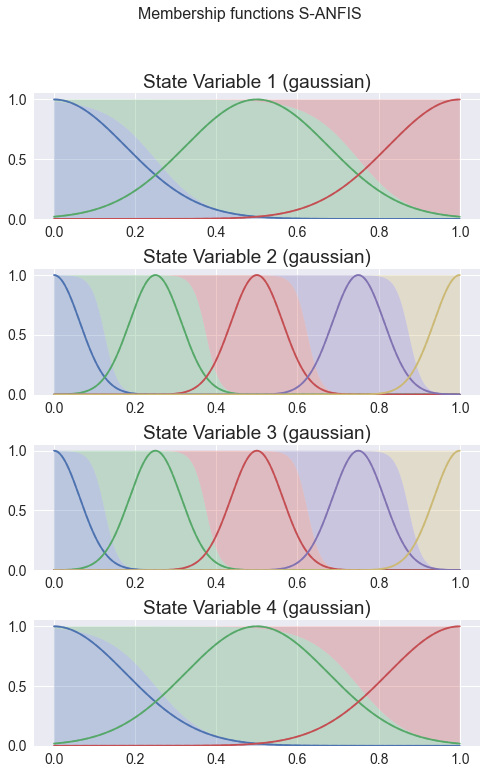

In [13]:
modelo.plotmfs(bounds=[[0,1], [0,1], [0,1], [0,1]])

In [14]:
history = modelo.fit(
    train_data=[x_treino, y_treino[:, -1].reshape(-1, 1)],
    valid_data=[x_teste, y_teste[:, -1].reshape(-1, 1)],
    loss_function=loss_functions,
    epochs=100,
    optimizer=optimizer,
    batch_size=2
)

Train s-anfis on 4199 samples, validate on 1800 samples


Training Loop: 100%|##########| 100.0/100 [05:39<00:00,  3.39s/epochs, train_loss=5e-5, valid_loss=0.00149] 


In [108]:
modelo.predict(x_treino).shape
y_treino[:,-1].reshape(-1,1)

tensor([[0.4992],
        [0.5025],
        [0.5058],
        ...,
        [0.6016],
        [0.6016],
        [0.6016]])

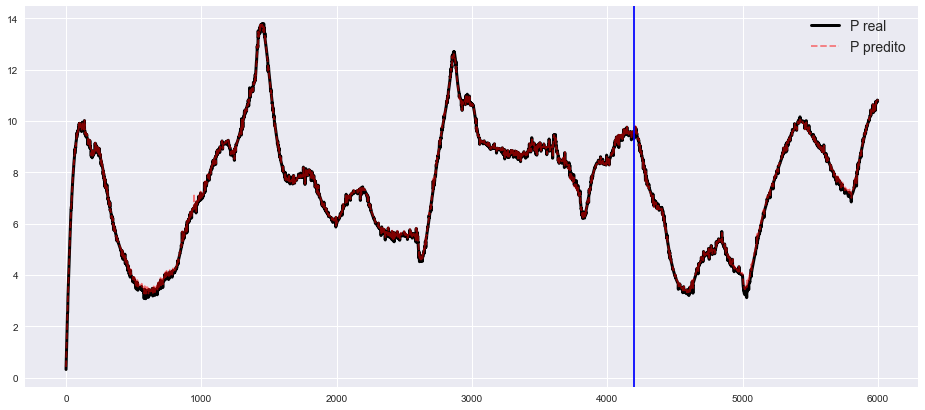

In [15]:
Y_Predito = np.concatenate([modelo.predict(x_treino), modelo.predict(x_teste)], axis=0)
Y_real = np.concatenate([y_treino[:, -1].reshape(-1,1), y_teste[:, -1].reshape(-1,1)], axis=0)

Y_Predito = sc2.inverse_transform(Y_Predito)
Y_real = sc2.inverse_transform(Y_real)
# plt.plot(modelo.predict(x_treino), c='r')
# plt.plot(y_treino[:,-1], c='r', ls='-')
plt.figure(figsize=(16,7))
plt.plot(Y_real, c='k', lw=3, label='P real')
plt.plot(Y_Predito, c='r', alpha=0.5, label='P predito', linestyle='--')

plt.axvline(int(f_treino*len(D)), c='b')
plt.legend(fontsize=14)

Text(0, 0.5, 'P predito')

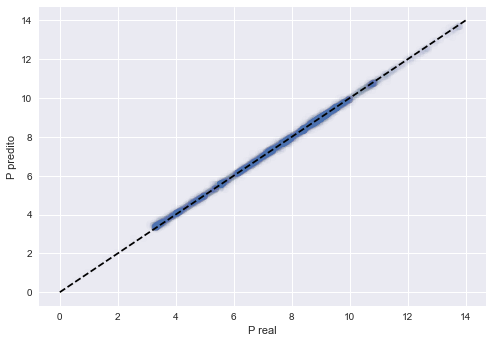

In [16]:
plt.scatter(Y_real, Y_Predito, alpha=0.01)
plt.plot([0,14], [0,14], ls='--', c='k')
plt.xlabel("P real")
plt.ylabel("P predito")

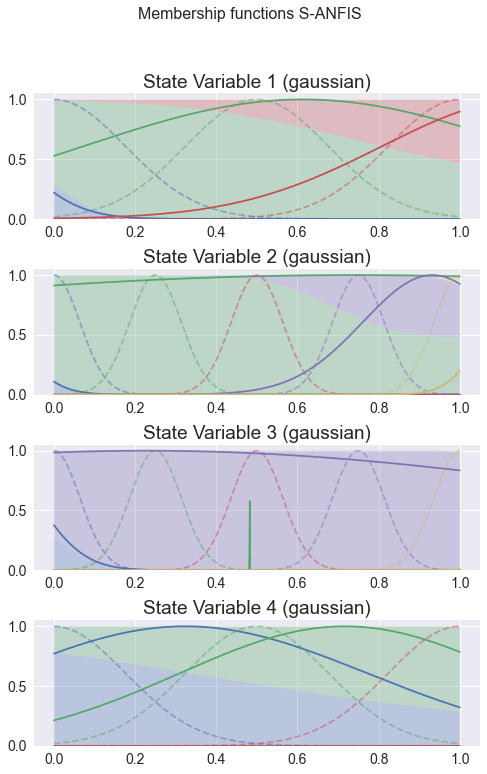

In [17]:
modelo.plotmfs(bounds=[[0,1], [0,1], [0,1], [0,1]])

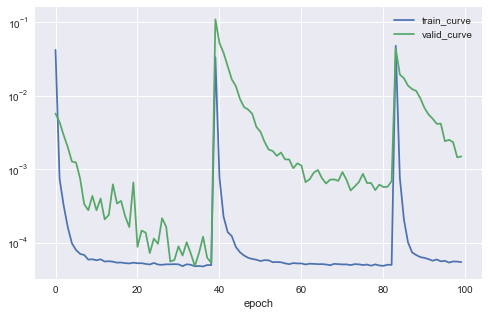

In [18]:
plottingtools.plt_learningcurves(history)

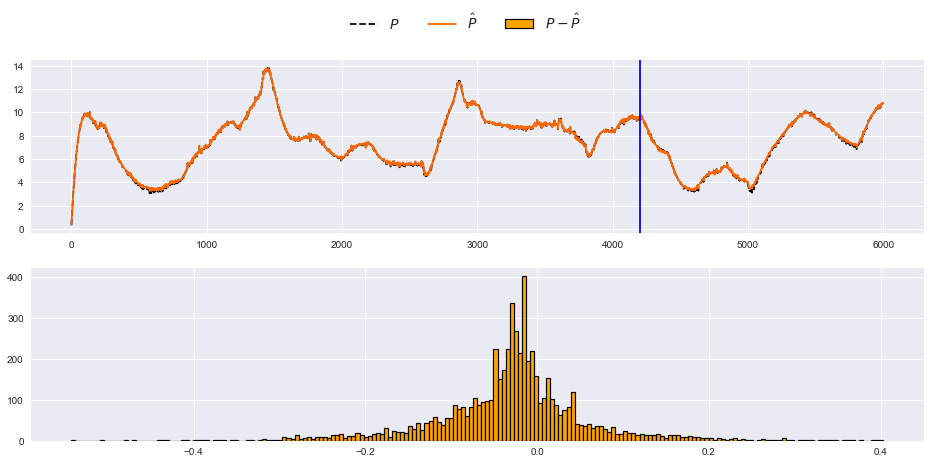

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,7))
ax1.plot(Y_real, label='$P$', c='k', linestyle='--')
ax1.plot(Y_Predito, label='$\hat P$', c='#FA6700', linestyle='-')
ax1.axvline(int(f_treino*len(D)), c='b')

ax2.hist(Y_real-Y_Predito, bins=200, label='$P - \hat{P}$', edgecolor='black', lw=1.2, color='orange')

fig.legend(loc="upper center", ncol=3, fontsize=14);
plt.savefig("Imagens/resultadoANFIS.jpg", format='jpg', dpi=500, bbox_inches="tight")

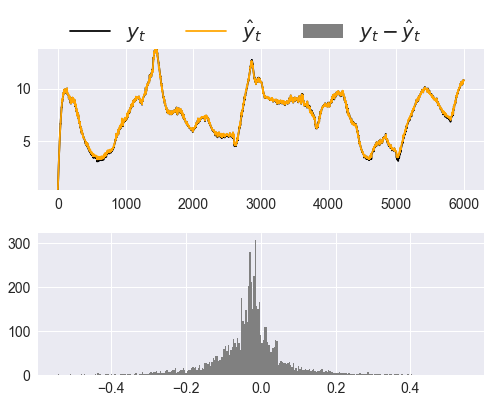

In [29]:
import pickle
pickle.dump(modelo, open("modelos/ANFIS.p", "wb"))
pickle.dump(sc, open("modelos/Scaler.p", "wb"))

plottingtools.plt_prediction(Y_real, Y_Predito)

# TESTE EM PLANTA NOVA

In [1]:
planta = np.loadtxt("Dados/planta_teste_X.csv", delimiter=',')
tempo = np.loadtxt("Dados/planta_teste_T.csv", delimiter=',')

Vt = planta[:, 0]
Xt = planta[:, 1]
St = planta[:, 2]
Pt = planta[:, 3]

# plt.plot(tempo, Vt)
# plt.plot(tempo, St)
# plt.plot(tempo, Xt)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,12))

ax1.plot(tempo, Vt, c='k', lw=2)
ax1.set_title("V (L)", size=12)
ax2.plot(tempo, Xt, c='k', lw=2)
ax2.set_title("X (g/L)", size=12)
ax3.plot(tempo, St, c='k', lw=2)
ax3.set_title("S (g/L)", size=12)
ax4.plot(tempo, Pt, c='k', lw=2)
ax4.set_title("P (g/L)", size=12);

NameError: name 'np' is not defined

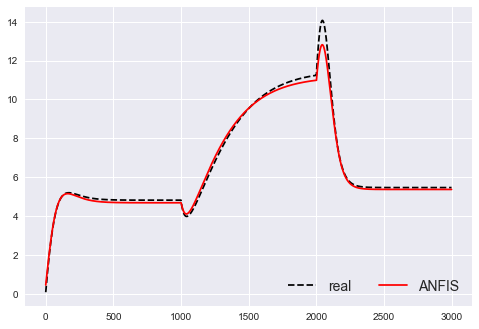

In [144]:
RNN = keras.models.load_model("modelos/RNN")

PLANTA = series_to_supervised(planta, 1, 1)

P = torch.Tensor(PLANTA.iloc[:, -1].values).reshape(-1,1)
PLANTA_n = sc.transform(PLANTA)
x_normalizado = torch.Tensor(PLANTA_n[:, :-4])

y_predito_ANFIS = sc2.inverse_transform(modelo.predict(x_normalizado))

# plt.xlim(-1, 1001)
plt.tight_layout()
plt.plot(range(len(P)), P, c='k', label='real', ls='--')
plt.plot(range(len(P)), y_predito_ANFIS, c='r', label='ANFIS')
plt.legend(loc=4, fontsize=14, ncol=2);

In [149]:
teste=pickle.load(open("modelos/ANFIS.p", "rb"))

In [150]:
teste.predict(x_treino)

tensor([[0.5020],
        [0.5053],
        [0.5078],
        ...,
        [0.5994],
        [0.5925],
        [0.6031]])